# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [79]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from scipy.signal import periodogram

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [80]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [81]:
data2 = pd.read_parquet(Path("data") / "test.parquet")

In [82]:
data3 = pd.concat([data, data2])

We can check general information about different columns,

In [25]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496771 entries, 48321 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496771 non-null  category      
 1   counter_name               496771 non-null  category      
 2   site_id                    496771 non-null  int64         
 3   site_name                  496771 non-null  category      
 4   bike_count                 496771 non-null  float64       
 5   date                       496771 non-null  datetime64[ns]
 6   counter_installation_date  496771 non-null  datetime64[ns]
 7   counter_technical_id       496771 non-null  category      
 8   latitude                   496771 non-null  float64       
 9   longitude                  496771 non-null  float64       
 10  log_bike_count             496771 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

and in particular the number of unique entries in each column,

In [24]:
data3.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8973
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [28]:
data3.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(100).to_csv("bike counts vs counters.csv")

# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [7]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(
    axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<AxesSubplot: xlabel='date'>

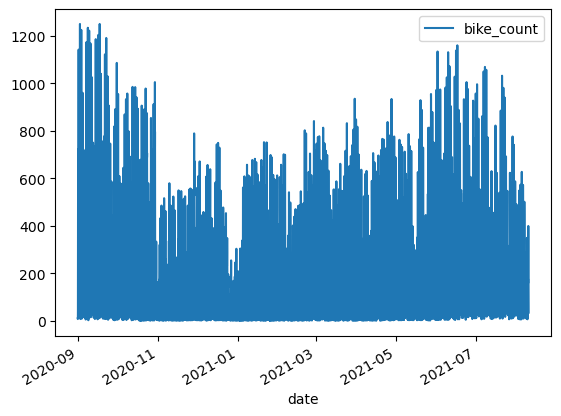

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<AxesSubplot: xlabel='date'>

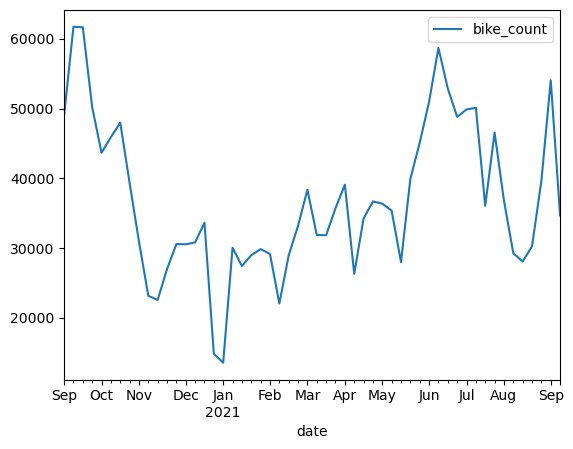

In [20]:
mask = data3["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data3[mask].groupby(pd.Grouper(freq="1w", key="date"))[
    ["bike_count"]].sum().plot()

In [30]:
# Count rows where 'bike_count' is 0 in 'data' dataframe
count_zeros_data = (data["bike_count"] == 0).sum()

# Count rows where 'bike_count' is 0 in 'data2' dataframe
count_zeros_data2 = (data2["bike_count"] == 0).sum()

print("Number of rows in 'data' where 'bike_count' is 0:", count_zeros_data)
print("Number of rows in 'data2' where 'bike_count' is 0:", count_zeros_data2)

Number of rows in 'data' where 'bike_count' is 0: 40104
Number of rows in 'data2' where 'bike_count' is 0: 1287


In [32]:
# Filter rows where 'bike_count' is 0 and select 'site_name' and 'counter_name' in 'data' dataframe
zero_bike_counts_data = data[data["bike_count"] == 0][["site_name", "counter_name"]]

# Filter rows where 'bike_count' is 0 and select 'site_name' and 'counter_name' in 'data2' dataframe
zero_bike_counts_data2 = data2[data2["bike_count"] == 0][["site_name", "counter_name"]]

print("Rows in 'data' where 'bike_count' is 0:")
print(zero_bike_counts_data)

print("\nRows in 'data2' where 'bike_count' is 0:")
print(zero_bike_counts_data2)

Rows in 'data' where 'bike_count' is 0:
                   site_name                counter_name
48321   28 boulevard Diderot    28 boulevard Diderot E-O
48327   28 boulevard Diderot    28 boulevard Diderot E-O
48339   28 boulevard Diderot    28 boulevard Diderot E-O
48342   28 boulevard Diderot    28 boulevard Diderot E-O
48360   28 boulevard Diderot    28 boulevard Diderot E-O
...                      ...                         ...
927228  254 rue de Vaugirard  254 rue de Vaugirard SO-NE
927406  254 rue de Vaugirard  254 rue de Vaugirard SO-NE
928156  254 rue de Vaugirard  254 rue de Vaugirard SO-NE
928192  254 rue de Vaugirard  254 rue de Vaugirard SO-NE
928347  254 rue de Vaugirard  254 rue de Vaugirard SO-NE

[40104 rows x 2 columns]

Rows in 'data2' where 'bike_count' is 0:
                   site_name                counter_name
56483   28 boulevard Diderot    28 boulevard Diderot E-O
56498   28 boulevard Diderot    28 boulevard Diderot E-O
56507   28 boulevard Diderot    28 bo

<AxesSubplot: xlabel='date'>

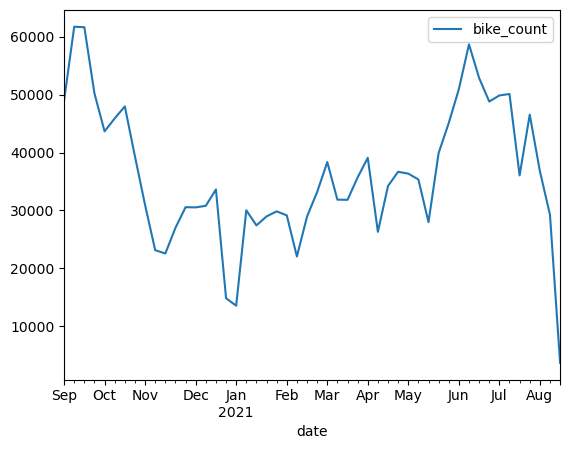

In [21]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[
    ["bike_count"]].sum().plot()

In [33]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496771 entries, 48321 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496771 non-null  category      
 1   counter_name               496771 non-null  category      
 2   site_id                    496771 non-null  int64         
 3   site_name                  496771 non-null  category      
 4   bike_count                 496771 non-null  float64       
 5   date                       496771 non-null  datetime64[ns]
 6   counter_installation_date  496771 non-null  datetime64[ns]
 7   counter_technical_id       496771 non-null  category      
 8   latitude                   496771 non-null  float64       
 9   longitude                  496771 non-null  float64       
 10  log_bike_count             496771 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [38]:
filtered_data = data3[data3["counter_name"]
                      == "Totem 73 boulevard de Sébastopol S-N"]

In [43]:
def plot_periodogram(ts, detrend="linear"):
    # Assume 1 sample per day, so the frequency is the number of days in a year (non-leap year)
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )

    # Exclude the zero frequency to avoid division by zero
    frequencies = frequencies[1:]
    spectrum = spectrum[1:]

    # Convert frequencies to periods
    periods = 1 / frequencies

    # Begin plotting, setting the figure size to make the plot wider
    fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the figsize to your needs
    ax.step(periods, spectrum, color="purple")
    ax.set_xscale("log")

    # Define the ticks for the periods you want to annotate
    period_ticks = [1, 1 / 2, 1 / 4, 1 / 6, 1 / 12, 1 / 26, 1 / 52, 1 / 104]
    ax.set_xticks(period_ticks)
    ax.set_xticklabels(
        [
            "Annual",
            "Semiannual",
            "Quarterly",
            "Bimonthly",
            "Monthly",
            "Biweekly",
            "Weekly",
            "Semiweekly",
        ],
        rotation=30,
    )

    # Invert x-axis to show periods instead of frequencies
    ax.invert_xaxis()

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_xlabel("Period (cycles per year)")
    ax.set_title("Periodogram")

    plt.show()

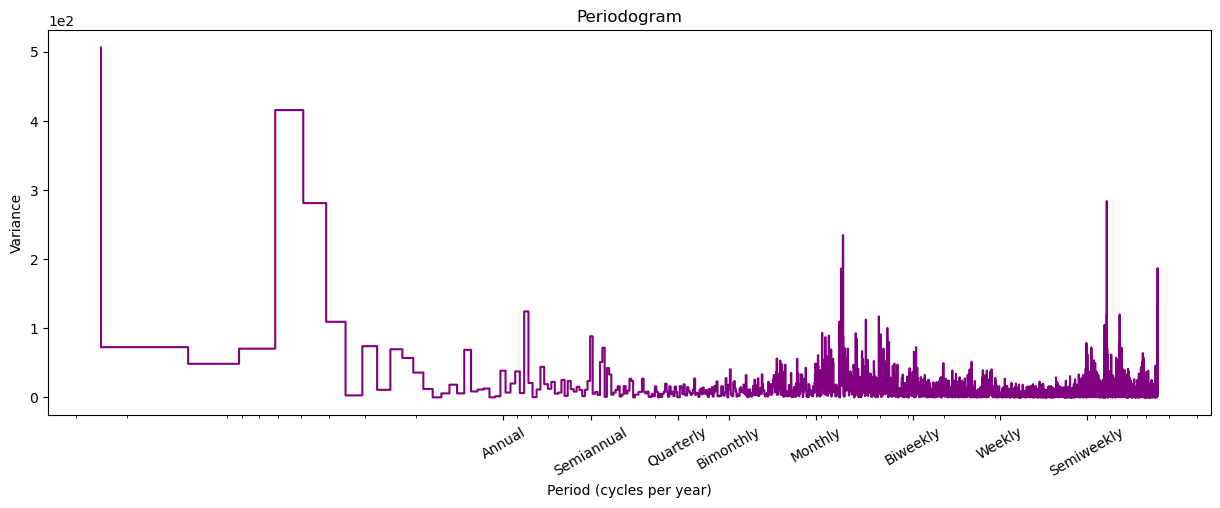

In [44]:
plot_periodogram(filtered_data["bike_count"])

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<AxesSubplot: xlabel='date'>

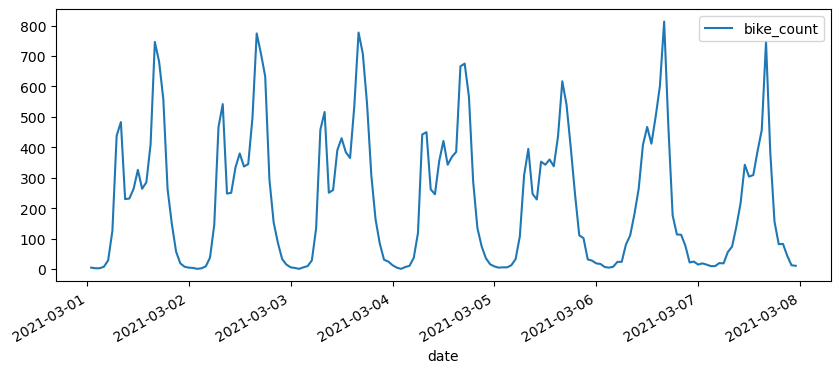

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data3["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data3["date"] > pd.to_datetime("2021/03/01"))
    & (data3["date"] < pd.to_datetime("2021/03/08"))
)

data3[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

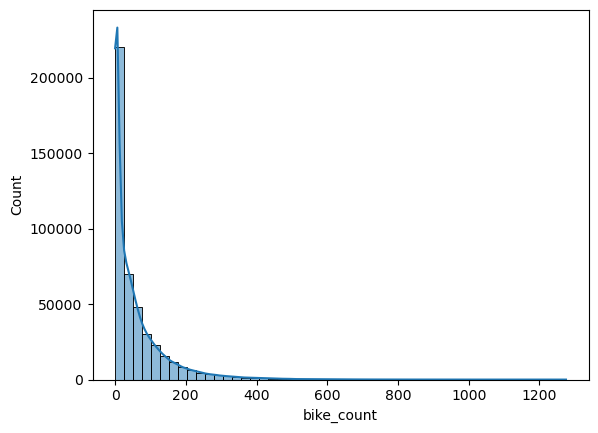

In [47]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

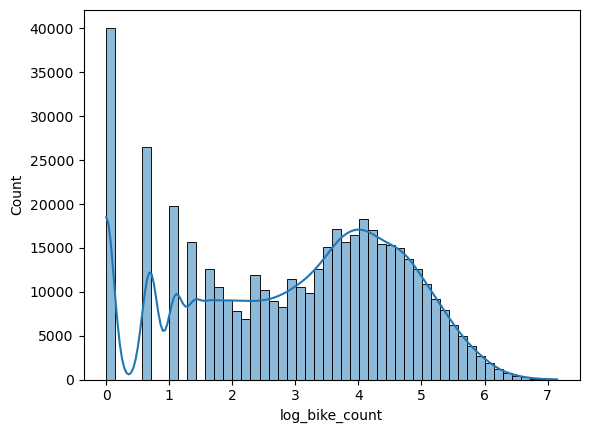

In [48]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [ ]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [ ]:
data["date"].head()

In [ ]:
_encode_dates(data[["date"]].head())

To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [ ]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [ ]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [ ]:
X_train.head(2)

and

In [ ]:
y_train

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [ ]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

In [ ]:
_encode_dates(X_train[["date"]]).columns.tolist()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [ ]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

# SGD

In [ ]:
X_train.info()

In [ ]:
from sklearn.linear_model import SGDRegressor

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

sgd_regressor = SGDRegressor(
    loss="huber",
)

pipe = make_pipeline(date_encoder, preprocessor, sgd_regressor)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

In [ ]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [ ]:
import joblib

joblib.dump(pipe, "SGD_init_pipeline.joblib")

# CATboost

In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
X_train.info()

In [ ]:
for feature in categorical_cols:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)

In [ ]:
cols_to_drop = ["counter_id", "site_id", "date", "counter_installation_date"]

In [ ]:
categorical_cols = [
    "counter_name",
    "site_name",
    "counter_technical_id",
    "day_of_week",
    "month",
    "hour",
]
numerical_cols = ["latitude", "longitude"]

In [ ]:
X_train = X_train.drop(cols_to_drop, axis=1)

In [ ]:
X_test = X_test.drop(cols_to_drop, axis=1)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

In [ ]:
cat_reg = CatBoostRegressor(
    iterations=1000,  # Specify the maximum number of boosting rounds
    early_stopping_rounds=10,
    verbose=True,
)

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Split the data into training and validation sets

    # Create CatBoost dataset
    train_pool_optuna = Pool(X_train, y_train, cat_features=categorical_cols)
    val_pool_optuna = Pool(X_test, y_test, cat_features=categorical_cols)

    # Define hyperparameters to be optimized
    params = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "depth": trial.suggest_int("depth", 6, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
    }

    # Create CatBoostRegressor instance
    cat_reg_optuna = CatBoostRegressor(
        cat_features=categorical_cols,
        early_stopping_rounds=10,
        **params,
    )

    # Train the model
    cat_reg_optuna.fit(train_pool_optuna, eval_set=val_pool_optuna)

    # Predict on the validation set
    val_preds_optuna = cat_reg_optuna.predict(X_test)

    # Calculate the mean squared error
    mse_optuna = mean_squared_error(y_test, val_preds_optuna)

    return mse_optuna

In [ ]:
study = optuna.create_study(direction="minimize")

In [ ]:
study.optimize(objective, n_trials=10)

In [ ]:
print("Best Hyperparameters:", study.best_params)

In [ ]:
best_params = study.best_params

In [ ]:
best_params = {
    "iterations": 1402,
    "depth": 10,
    "learning_rate": 0.03073417636647055,
    "l2_leaf_reg": 9.871350035301967,
}

In [ ]:
train_pool = Pool(
    X_train, y_train, cat_features=categorical_cols, feature_names=list(
        X_train.columns)
)

In [ ]:
test_pool = Pool(
    X_test, y_test, cat_features=categorical_cols, feature_names=list(
        X_test.columns)
)

In [ ]:
best_cat_reg = CatBoostRegressor(
    cat_features=categorical_cols, verbose=True, **best_params
)

In [ ]:
best_cat_reg.fit(train_pool, eval_set=test_pool)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
catboost_predictions = best_cat_reg.predict(X_train)

In [ ]:
catboost_predictions_2d = np.expand_dims(catboost_predictions, axis=1)

In [ ]:
ada_boost = AdaBoostRegressor(
    base_estimator=None,  # Set to None since we are providing our own predictions
    n_estimators=50,
    random_state=42,
    learning_rate=0.1,
)

In [ ]:
ada_boost.fit(catboost_predictions_2d, y_train)

In [ ]:
test_pool = Pool(
    X_test, y_test, cat_features=categorical_cols, feature_names=list(
        X_test.columns)
)

In [ ]:
catboost_predictions_test = best_cat_reg.predict(test_pool)

# Convert predictions to 2D array
catboost_predictions_2d_test = np.expand_dims(
    catboost_predictions_test, axis=1)

In [ ]:
ada_boost_predictions_train = ada_boost.predict(catboost_predictions_2d)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, ada_boost_predictions_train))

print(f"Root Mean Squared Error (RMSE) on training data: {rmse_train}")

In [ ]:
# Get AdaBoost predictions for test set
ada_boost_predictions_test = ada_boost.predict(catboost_predictions_2d_test)

# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_test, ada_boost_predictions_test))

print(f"Root Mean Squared Error (RMSE) on test data: {rmse_test}")

In [ ]:
# Get CatBoost predictions for training set
catboost_predictions_train = best_cat_reg.predict(train_pool)

# Calculate RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y_train, catboost_predictions_train))
print(f"Root Mean Squared Error (RMSE) on training data: {rmse_train}")

# Assuming X_test and y_test are your test data
# Replace 'counter_name' with the actual name of your categorical feature
# Specify feature names for the test set
feature_names_test = X_test.columns.tolist()

# Create CatBoost Pool for test set
test_pool = Pool(
    X_test, y_test, cat_features=categorical_cols, feature_names=feature_names_test
)

# Get CatBoost predictions for test set
catboost_predictions_test = best_cat_reg.predict(test_pool)

# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_test, catboost_predictions_test))
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_test}")

In [ ]:
cat_reg.fit(train_pool, eval_set=test_pool)

In [ ]:
joblib.dump(cat_reg, "CatBoost_model_basic.joblib")

In [ ]:
import joblib